In [2]:
import numpy as np
from scipy.fftpack import fft2, fftshift, ifft2
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.misc import imread
from scipy.sparse.linalg import LinearOperator, svds
from pywt import wavedec2, waverec2, coeffs_to_array, array_to_coeffs
from collections import namedtuple
from math import sqrt

import time
import pylab as pl
from IPython import display


C:\Users\Marco\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


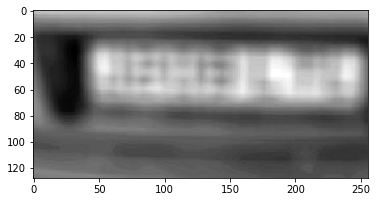

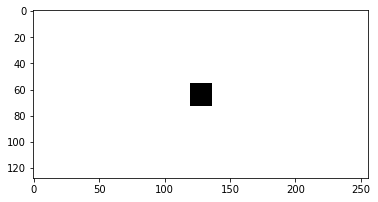

(32768, 289)


In [3]:
# Mappings between n dimensional complex space and 2n dimensional real space
real2comp = lambda x: x[0:int(x.shape[0]/2)] + 1j*x[int(x.shape[0]/2):]
comp2real = lambda x: np.append(x.real, x.imag)

# Load Data
x = imread('blurredplate.jpg',flatten=True,mode='F')
x = x[60:188,40:296]
x = x/np.linalg.norm(x,ord=np.inf)
#x = x/np.linalg.norm(x)
imsize1 = x.shape[0]
imsize2 = x.shape[1]
imsize = imsize1*imsize2

# Shows the blurred image!
plt.imshow(x, cmap='gray')
plt.show()

# Reshaping operators matrix to vector and vector to matrix
mat = lambda x: np.reshape(x,[imsize1,imsize2])
vec = lambda x: x.flatten()

# Set the measurement vector b
b = comp2real(vec(fft2(fftshift(x)))) # vector of around 65k values

# Roughly estimate the support of the blur kernel
K1 = 17
K2 = 17
Indw = np.zeros([imsize1,imsize2])
ind1 = np.int(imsize1/2-(K1+1)/2+1)
ind2 = np.int(imsize1/2+(K1+1)/2)
ind3 = np.int(imsize2/2-(K2+1)/2+1)
ind4 = np.int(imsize2/2+(K2+1)/2)
Indw[ind1:ind2,ind3:ind4] = 1
#above, for implementational simplicity we assume K1 and K2 odd, even  
#if they are even 1 pixel probably won't cause much trouble
plt.imshow(-Indw, cmap='gray') # Shows the estimated support of blur kernel!
plt.show()
Indw = vec(Indw);
kernelsize = np.count_nonzero(Indw)
Indi = np.nonzero(Indw > 0)[0]
Indv = Indw[Indi]

# Define operators Bop and Cop
Bmat = sps.csr_matrix((Indv,(Indi,range(0,kernelsize))),shape=(imsize,kernelsize))
print(Bmat.shape)
Bop = lambda x: mat(Bmat.dot(x))
BTop = lambda x: Bmat.T.dot(vec(x))

# Compute and display wavelet coefficients of the original and blurred image
l = coeffs_to_array(wavedec2(x, 'db1', level=4))[1]
Cop = lambda x: waverec2(array_to_coeffs(mat(x),l,output_format='wavedec2'),'db1')
CTop = lambda x: coeffs_to_array(wavedec2(x, 'db1', level=4))[0]

# Define operators
Aoper = lambda m,n,h: comp2real(1.0/sqrt(imsize)*n*vec(fft2(Cop(m))*fft2(Bop(h))))
AToper = {"matvec": lambda y,w: CTop(np.real(fft2(mat(np.conj(real2comp(y))*vec(fft2(Bop(w)))))))/sqrt(y.shape[0]/2.0),
         "rmatvec": lambda y,w: BTop(np.real(ifft2(mat(real2comp(y)*vec(ifft2(Cop(w)))))))*(y.shape[0]/2.0)**1.5}


In [4]:
def plotFunc(mEst, C, x):
    
    xEst = -C(mEst);
    xEst = xEst - min(xEst.flatten())
    xEst = xEst/max(xEst.flatten())
    plt.imshow(xEst, cmap='gray',hold=False)
    plt.show()


In [27]:
def FrankWolfe(Aoper, AToper, b, n1, n2, kappa, maxit, plotFunc):
# PURPOSE: We will solve the following problem formulation with
# Frank-Wolfe's method.                                    
#                   min_x  0.5*norm(A(x) - b)^2        
#                   s.t.:  norm_nuc(x) <= kappa,     
#
# Laboratory for Information and Inference Systems (LIONS)
# Ecole Polytechnique Federale de Lausanne (EPFL) - SWITZERLAND
# Last modification: November 26, 2017
    
    # Print the caption
    
    #Initialize 
    AX_t = 0.0   # zeros
    X = 0.0      # zeros
    
    # keep track of objective value
    fx = np.array([])
        
    # The main loop    
    for iteration in range(0, maxit+1):
        
        # Print the objective values ...
        fx = np.append(fx, 0.5*np.linalg.norm(AX_t - b,2)**2)
        print('{:03d} | {:.4e}'.format(iteration, fx[-1]))

        # Form the residual and fix the operator to be used in svds.
        res_cur = AX_t - b

        ATop1 = lambda w: AToper["matvec"](res_cur,w)
        ATop2 = lambda w: AToper["rmatvec"](res_cur,w)
        svdsArg = LinearOperator((n2,n1), matvec=ATop1, rmatvec=ATop2)
        topLe_vec, singVal, topRe_vec = svds(svdsArg, k=1, tol=1e-4, which='LM')
        # Note: we could also used svds. Lansvd and svds solve the same problem with similar
        # but different approaches. Svds in older versions of Matlab does not accept function
        # handles as inputs, this is why we rather used lansvd here. If you run into trouble
        # with lansvd on your computer, try to use svds (with properly modifying the inputs)
        
        # Apply A to the rank 1 update
        AXsharp_t = Aoper(topLe_vec, -kappa, topRe_vec.T)
        
        # Step size
        weight = 2.0/(iteration+2)
        
        # Update A*X
        AX_t = (1.0-weight)*AX_t + weight*(AXsharp_t)
        
        # Update X
        X = (1.0 - weight)*X + weight*(-kappa*np.outer(topLe_vec, topRe_vec))
        
        # Show the reconstruction (at every 10 iteration) 
        if (iteration%200 == 0):
            U,S,V = np.linalg.svd(X,full_matrices=0,compute_uv=1)
            plotFunc(U[:,0])

    return X
    

### KAPPA = 150 ###
000 | 4.1535e+03


C:\Users\Marco\Anaconda3\lib\site-packages\matplotlib\pyplot.py:3198: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


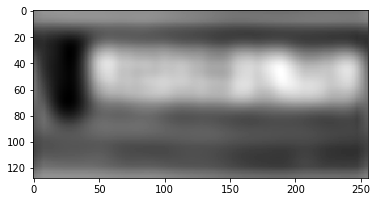

001 | 2.9566e+06
002 | 4.4299e+05
003 | 2.8640e+05
004 | 1.7951e+05
005 | 8.8432e+04
006 | 1.0230e+05
007 | 3.8211e+04
008 | 6.8647e+04
009 | 1.9312e+04
010 | 5.0655e+04
011 | 1.0632e+04
012 | 3.9754e+04
013 | 6.1455e+03
014 | 3.2561e+04
015 | 3.6441e+03
016 | 2.7512e+04
017 | 2.1791e+03
018 | 2.3796e+04
019 | 1.2946e+03
020 | 2.0956e+04
021 | 7.5241e+02
022 | 1.8715e+04
023 | 4.2003e+02
024 | 1.6897e+04
025 | 2.1976e+02
026 | 1.5383e+04
027 | 1.0405e+02
028 | 1.4082e+04
029 | 4.2638e+01
030 | 1.2916e+04
031 | 1.5308e+01
032 | 1.1751e+04
033 | 7.6017e+00
034 | 1.0203e+04
035 | 2.1646e+01
036 | 8.3476e+03
037 | 9.2344e+01
038 | 6.5641e+03
039 | 2.2801e+02
040 | 5.0496e+03
041 | 4.1298e+02
042 | 3.8455e+03
043 | 6.2492e+02
044 | 2.8995e+03
045 | 8.4919e+02
046 | 2.1645e+03
047 | 1.0746e+03
048 | 1.5966e+03
049 | 1.2939e+03
050 | 1.1605e+03
051 | 1.5023e+03
052 | 8.2784e+02
053 | 1.6971e+03
054 | 5.7656e+02
055 | 1.8764e+03
056 | 3.8922e+02
057 | 2.0391e+03
058 | 2.5217e+02
059 | 2.1844e+

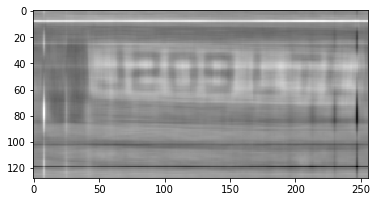

In [28]:
# Run Frank-Wolfe's method
MaxIters = 200
kappa = 150
print("### KAPPA = %d ###" %kappa)
plotF = lambda m: plotFunc(m,Cop,x)
xFW = FrankWolfe(Aoper, AToper, b, kernelsize, imsize, kappa, MaxIters, plotF)

In [20]:
# NOTE: This experiment is based on the theory and the codes publised in
#'Blind Deconvolution using Convex Programming' by A.Ahmed, B.Recht and J.Romberg.